In [1]:
import numpy as np
import pandas as pd
import requests as requests
import time as time
import hmac
import hashlib
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df= pd.read_csv('BTC_with_Gold_USD_minute.csv')
print(df.head())  
print(df.shape)  

     close     high      low     open                       time  volume  \
0  87090.5  87113.0  87090.5  87113.0  2025-04-21 23:01:00+00:00      14   
1  87082.0  87096.5  87052.0  87080.5  2025-04-21 23:02:00+00:00      21   
2  87092.0  87092.0  87078.0  87078.0  2025-04-21 23:03:00+00:00      15   
3  87028.5  87083.5  87028.5  87083.5  2025-04-21 23:04:00+00:00      14   
4  87017.5  87028.5  87000.0  87028.5  2025-04-21 23:05:00+00:00      50   

   gold_close_gc=f  gold_high_gc=f  gold_low_gc=f  gold_open_gc=f  \
0      3445.300049     3455.899902    3440.199951     3442.399902   
1      3445.300049     3455.899902    3440.199951     3442.399902   
2      3445.300049     3455.899902    3440.199951     3442.399902   
3      3445.300049     3455.899902    3440.199951     3442.399902   
4      3445.300049     3455.899902    3440.199951     3442.399902   

   gold_volume_gc=f  usd_close_dx=f  usd_high_dx=f  usd_low_dx=f  \
0               0.0       98.245003          98.32     98.12

In [115]:
print(df["gold_return"].unique().shape)

(1634,)


In [3]:
df["btc_return"] = df["close"].pct_change()
df["gold_return"] = df["gold_close_gc=f"].pct_change()
df["usd_return"] = df["usd_close_dx=f"].pct_change()

In [120]:
print(df["gold_return"].unique().shape)

(1635,)


In [4]:
window = 60
df["btc_momentum"] = df["btc_return"].rolling(window).mean()
df["btc_volatility"] = df["btc_return"].rolling(window).std()
df["btc_volume_mean"] = df["volume"].rolling(window).mean()

df["gold_momentum"] = df["gold_return"].rolling(window).mean()
df["gold_volatility"] = df["gold_return"].rolling(window).std()

df["usd_momentum"] = df["usd_return"].rolling(window).mean()
df["usd_volatility"] = df["usd_return"].rolling(window).std()

In [121]:
print(df["gold_return"].unique().shape)

(1635,)


In [5]:
df["target"] = df["btc_return"].shift(-1)

In [6]:
drop_cols = [
    "open", "high", "low", "close", "volume",
    "gold_open_gc=f", "gold_high_gc=f", "gold_low_gc=f", "gold_close_gc=f", "gold_volume_gc=f",
    "usd_open_dx=f", "usd_high_dx=f", "usd_low_dx=f", "usd_close_dx=f", "usd_volume_dx=f"
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Final columns kept:")
print(df.columns.tolist())


Final columns kept:
['time', 'btc_return', 'gold_return', 'usd_return', 'btc_momentum', 'btc_volatility', 'btc_volume_mean', 'gold_momentum', 'gold_volatility', 'usd_momentum', 'usd_volatility', 'target']


In [7]:
cols = ['btc_return', 'gold_return', 'usd_return', 'btc_momentum',
       'btc_volatility', 'btc_volume_mean', 'gold_momentum', 'gold_volatility',
       'usd_momentum', 'usd_volatility', 'target', 'time']
df = df.copy()
df[cols] = (df[cols]
            .replace(["", "nan", "NaN"], pd.NA)
            .ffill()
            .bfill())


In [8]:
df.shape

(104000, 12)

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor   
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'ExtraTrees': ExtraTreesRegressor(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42, n_jobs=-1),
    'LGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}

param_grids = {
    'DecisionTree': {'max_depth':[5,10,15], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,3,5]},
    'RandomForest': {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,3,5]},
    'ExtraTrees': {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_split':[2,5,10]},
    'AdaBoost': {'n_estimators':[50,100,200], 'learning_rate':[0.01,0.05,0.1]},
    'GradientBoosting': {'n_estimators':[100,200], 'learning_rate':[0.01,0.05,0.1], 'max_depth':[3,4,5]},
    'XGB': {'n_estimators':[100,200,300], 'learning_rate':[0.01,0.05,0.1], 'max_depth':[4,6,8]},
    'LGBM': {'n_estimators':[100,200,300], 'learning_rate':[0.01,0.05,0.1], 'num_leaves':[31,50,70]}
}

In [10]:
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'btc_return_lag_{lag}'] = df['btc_return'].shift(lag)
    df[f'btc_volatility_lag_{lag}'] = df['btc_volatility'].shift(lag)


In [11]:
windows = [3, 6, 12, 24]
for w in windows:
    df[f'btc_return_rolling_mean_{w}'] = df['btc_return'].rolling(w).mean()
    df[f'btc_return_rolling_std_{w}'] = df['btc_return'].rolling(w).std()
    df[f'btc_momentum_rolling_mean_{w}'] = df['btc_momentum'].rolling(w).mean()

In [12]:
df['btc_gold_corr_6h'] = df['btc_return'].rolling(6).corr(df['gold_return'])
df['btc_usd_corr_6h'] = df['btc_return'].rolling(6).corr(df['usd_return'])
df['btc_gold_spread'] = df['btc_return'] - df['gold_return']
df['btc_usd_spread'] = df['btc_return'] - df['usd_return']
df['btc_gold_momentum_diff'] = df['btc_momentum'] - df['gold_momentum']
df['btc_usd_momentum_diff'] = df['btc_momentum'] - df['usd_momentum']

In [13]:
df['btc_volatility_sqrt'] = np.sqrt(df['btc_volatility'])
df['btc_momentum_sq'] = df['btc_momentum'] ** 2
df['log_btc_volume'] = np.log1p(df['btc_volume_mean'])
df['vol_mom_ratio'] = df['btc_momentum'] / (df['btc_volatility'] + 1e-6)

In [14]:
df['risk_on'] = ((df['gold_return'] < 0) & (df['btc_return'] > 0)).astype(int)
df['risk_off'] = ((df['gold_return'] > 0) & (df['btc_return'] < 0)).astype(int)


In [15]:
# Calculate correlation matrix and find high correlations
corr_matrix = df.drop(columns=['time']).corr().abs()
high_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if (corr_matrix.iloc[i, j] > 0.95):
            # Keep the first feature, drop the second
            high_corr_features.add(corr_matrix.columns[j])

features_to_drop = list(high_corr_features)
df_cleaned = df.drop(columns=features_to_drop)


In [16]:
final_df=df_cleaned

In [17]:
final_df.shape

(104000, 38)

In [86]:
final_df.describe()

,btc_return,gold_return,usd_return,btc_momentum,btc_volatility,btc_volume_mean,gold_momentum,gold_volatility,usd_momentum,usd_volatility,...,btc_gold_spread,btc_gold_momentum_diff,btc_volatility_sqrt,btc_momentum_sq,log_btc_volume,vol_mom_ratio,risk_on,risk_off,high_vol_regime,trend_regime
count,104000.000000,104000.0,104000.0,104000.000000,104000.000000,104000.000000,1.040000e+05,104000.000000,1.040000e+05,104000.000000,...,104000.000000,1.040000e+05,104000.000000,1.040000e+05,104000.000000,104000.000000,104000.0,104000.0,104000.000000,104000.000000
mean,0.000002,0.0,0.0,0.000003,0.000474,103.023080,8.766474e-07,0.000219,1.924845e-07,0.000083,...,0.000001,2.001583e-06,0.021147,4.413103e-09,4.435149,0.003896,0.0,0.0,0.480692,0.500163
std,0.000457,0.0,0.0,0.000062,0.000267,77.855225,4.003675e-05,0.000274,1.465714e-05,0.000100,...,0.000483,7.287080e-05,0.005165,1.116383e-08,0.621572,0.114539,0.0,0.0,0.499629,0.500002
min,-0.001386,0.0,0.0,-0.000191,0.000170,24.000000,-1.337975e-04,0.000000,-5.083419e-05,0.000000,...,-0.001554,-2.341616e-04,0.013025,2.799268e-13,3.218876,-0.258338,0.0,0.0,0.000000,0.000000
25%,-0.000236,0.0,0.0,-0.000031,0.000312,52.850000,-1.657529e-05,0.000058,-6.761137e-06,0.000019,...,-0.000240,-3.658466e-05,0.017659,2.253883e-10,3.986202,-0.078762,0.0,0.0,0.000000,0.000000
50%,0.000000,0.0,0.0,0.000001,0.000407,77.400000,0.000000e+00,0.000141,0.000000e+00,0.000053,...,0.000000,9.768265e-07,0.020172,1.045595e-09,4.361824,0.003853,0.0,0.0,0.000000,1.000000
75%,0.000239,0.0,0.0,0.000034,0.000549,124.087500,1.966104e-05,0.000272,7.595012e-06,0.000111,...,0.000242,4.036323e-05,0.023427,3.524607e-09,4.829013,0.084843,0.0,0.0,1.000000,1.000000
max,0.001395,0.0,0.0,0.000215,0.002025,443.550167,1.534406e-04,0.001828,4.267150e-05,0.000641,...,0.001544,2.278718e-04,0.045003,8.527944e-08,6.097063,0.277071,0.0,0.0,1.000000,1.000000


In [87]:
final_df['gold_return']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
103995    0.0
103996    0.0
103997    0.0
103998    0.0
103999    0.0
Name: gold_return, Length: 104000, dtype: float64

<Axes: >

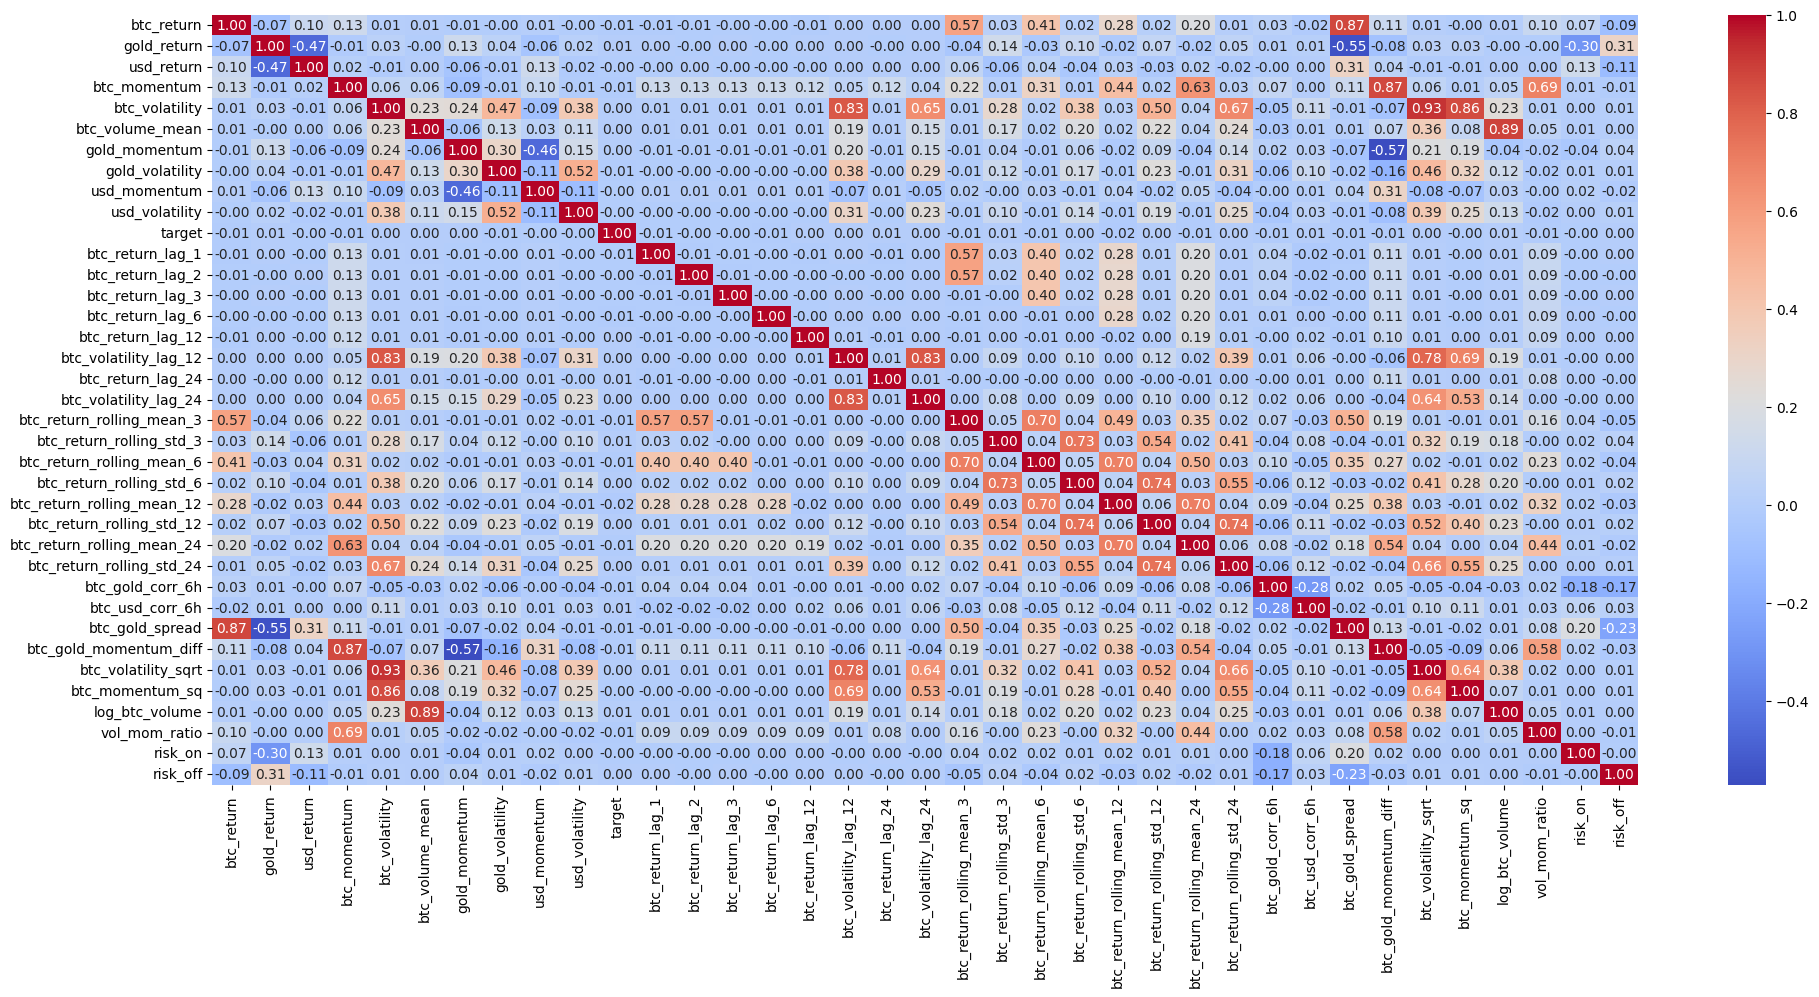

In [18]:
plt.figure(figsize=(23,10))
sns.heatmap(df_cleaned.drop(columns=['time']).corr(), annot=True, fmt=".2f", cmap='coolwarm')

<Axes: >

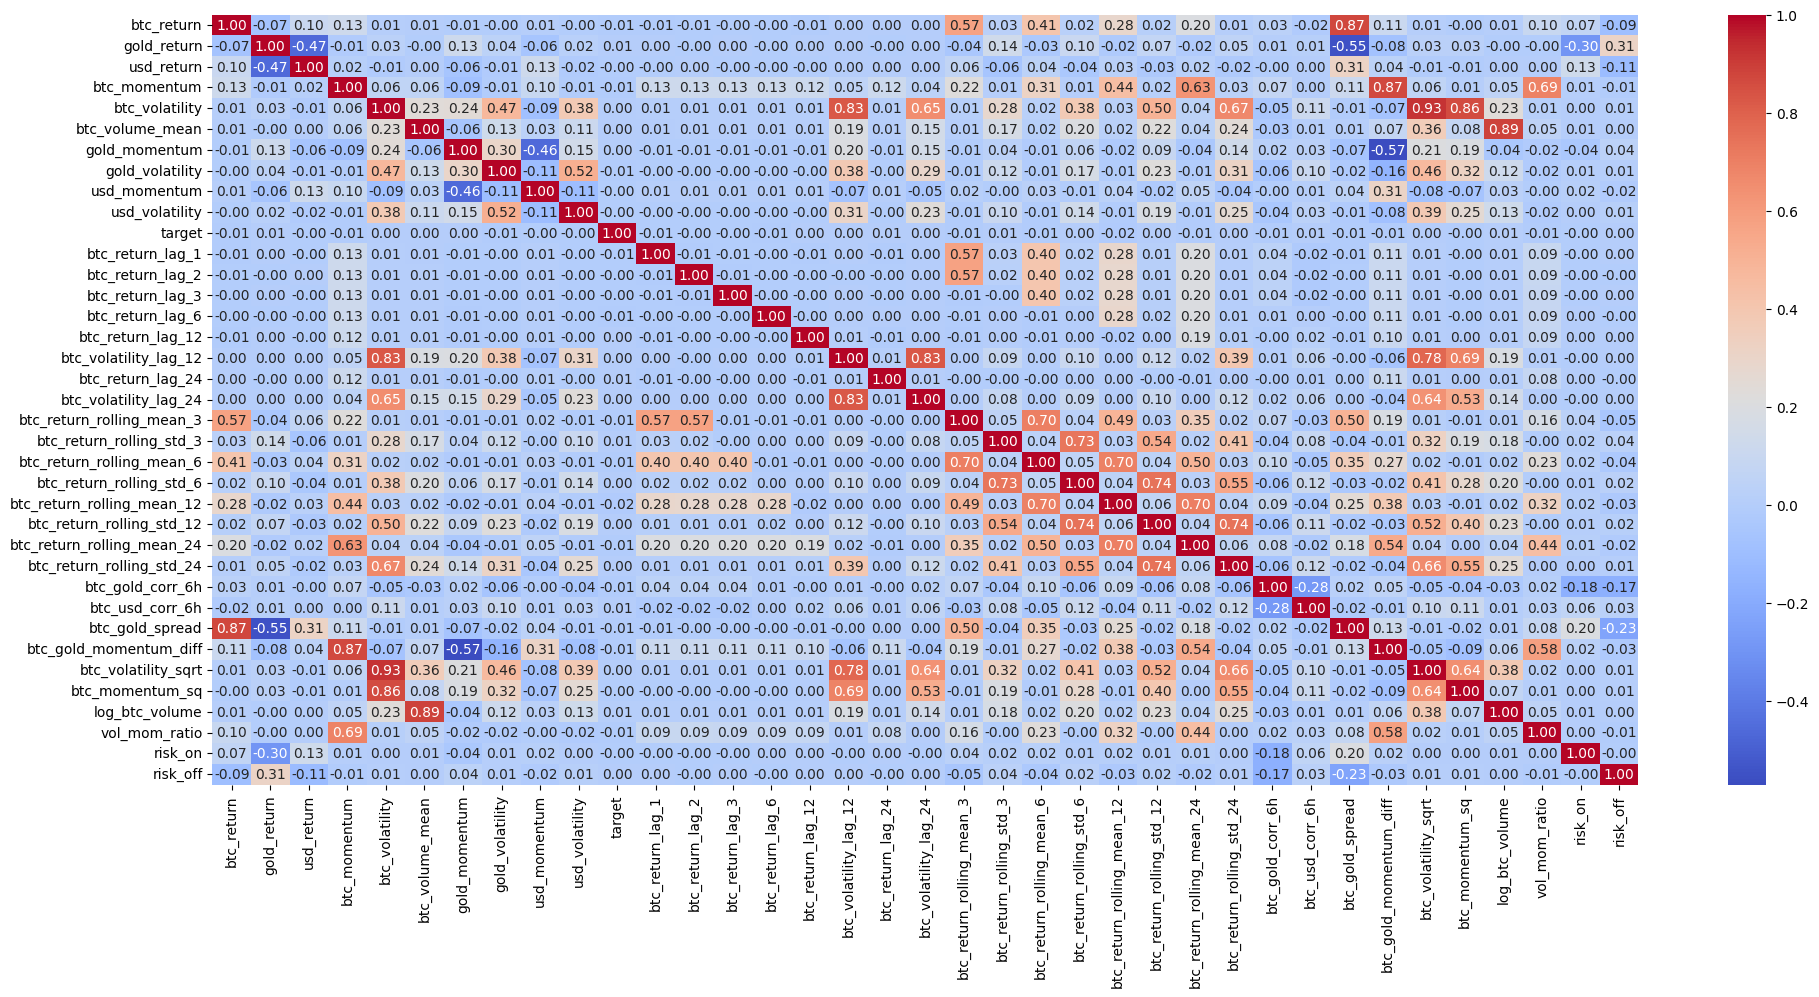

In [16]:
plt.figure(figsize=(23,10))
sns.heatmap(df_cleaned.drop(columns=['time']).corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [19]:

final_df['target'] =   final_df['btc_return'].rolling(12).std().shift(-12)
final_df['high_vol_regime'] = (final_df['btc_volatility'] > final_df['btc_volatility'].rolling(24).mean()).astype(int)
final_df['trend_regime'] = (final_df['btc_return_rolling_mean_24'] > 0).astype(int)


In [20]:
final_df.isnull().sum()

time                              0
btc_return                        0
gold_return                       0
usd_return                        0
btc_momentum                      0
btc_volatility                    0
btc_volume_mean                   0
gold_momentum                     0
gold_volatility                   0
usd_momentum                      0
usd_volatility                    0
target                           12
btc_return_lag_1                  1
btc_return_lag_2                  2
btc_return_lag_3                  3
btc_return_lag_6                  6
btc_return_lag_12                12
btc_volatility_lag_12            12
btc_return_lag_24                24
btc_volatility_lag_24            24
btc_return_rolling_mean_3         2
btc_return_rolling_std_3          2
btc_return_rolling_mean_6         5
btc_return_rolling_std_6          5
btc_return_rolling_mean_12       11
btc_return_rolling_std_12        11
btc_return_rolling_mean_24       23
btc_return_rolling_std_24   

In [21]:
cols = ['btc_return', 'gold_return', 'usd_return', 'btc_momentum',
       'btc_volatility', 'btc_volume_mean', 'gold_momentum', 'gold_volatility',
       'usd_momentum', 'usd_volatility', 'target', 'time',
       'btc_return_lag_1', 'btc_return_lag_2', 'btc_return_lag_3',
       'btc_return_lag_6', 'btc_return_lag_12', 'btc_volatility_lag_12',
       'btc_return_lag_24', 'btc_volatility_lag_24',
       'btc_return_rolling_mean_3', 'btc_return_rolling_std_3',
       'btc_return_rolling_mean_6', 'btc_return_rolling_std_6',
       'btc_return_rolling_mean_12', 'btc_return_rolling_std_12',
       'btc_return_rolling_mean_24', 'btc_return_rolling_std_24',
       'btc_gold_corr_6h', 'btc_usd_corr_6h', 'btc_gold_spread',
       'btc_gold_momentum_diff', 'btc_volatility_sqrt', 'btc_momentum_sq',
       'log_btc_volume', 'vol_mom_ratio', 'risk_on', 'risk_off']
final_df = final_df.copy()
final_df[cols] = (final_df[cols]
            .replace(["", "nan", "NaN"], pd.NA)
            .ffill()
            .bfill())

final_df.isnull().sum()

time                          0
btc_return                    0
gold_return                   0
usd_return                    0
btc_momentum                  0
btc_volatility                0
btc_volume_mean               0
gold_momentum                 0
gold_volatility               0
usd_momentum                  0
usd_volatility                0
target                        0
btc_return_lag_1              0
btc_return_lag_2              0
btc_return_lag_3              0
btc_return_lag_6              0
btc_return_lag_12             0
btc_volatility_lag_12         0
btc_return_lag_24             0
btc_volatility_lag_24         0
btc_return_rolling_mean_3     0
btc_return_rolling_std_3      0
btc_return_rolling_mean_6     0
btc_return_rolling_std_6      0
btc_return_rolling_mean_12    0
btc_return_rolling_std_12     0
btc_return_rolling_mean_24    0
btc_return_rolling_std_24     0
btc_gold_corr_6h              0
btc_usd_corr_6h               0
btc_gold_spread               0
btc_gold

In [22]:
final= pd.read_csv('final_df.csv')

In [23]:
final = pd.DataFrame(final)

In [24]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled = scaler.fit_transform(final_df.select_dtypes(include=np.number))
final_df_scaled = pd.DataFrame(scaled, columns=final_df.select_dtypes(include=np.number).columns)


In [25]:
def cap_outliers(df, cols=None, lower=0.01, upper=0.99):
    df_capped = df.copy()
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns
    
    for col in cols:
        lower_val = df_capped[col].quantile(lower)
        upper_val = df_capped[col].quantile(upper)
        df_capped[col] = np.clip(df_capped[col], lower_val, upper_val)
    return df_capped
final_df = cap_outliers(final_df, lower=0.01, upper=0.99)


In [26]:
df_capped = cap_outliers(final_df_scaled, lower=0.02, upper=0.98)
df_capped

,btc_return,gold_return,usd_return,btc_momentum,btc_volatility,btc_volume_mean,gold_momentum,gold_volatility,usd_momentum,usd_volatility,...,btc_gold_spread,btc_gold_momentum_diff,btc_volatility_sqrt,btc_momentum_sq,log_btc_volume,vol_mom_ratio,risk_on,risk_off,high_vol_regime,trend_regime
0,-0.205464,0.0,0.0,1.231451,-0.007869,0.002106,-1.214853,0.932516,0.000000,-0.580895,...,-0.202550,1.612437,-0.008023,1.673139,0.002268,1.196239,0.0,0.0,0.0,-1.0
1,-0.205464,0.0,0.0,1.231451,-0.007869,0.002106,-1.214853,0.932516,0.000000,-0.580895,...,-0.202550,1.612437,-0.008023,1.673139,0.002268,1.196239,0.0,0.0,0.0,-1.0
2,0.241746,0.0,0.0,1.231451,-0.007869,0.002106,-1.214853,0.932516,0.000000,-0.580895,...,0.238317,1.612437,-0.008023,1.673139,0.002268,1.196239,0.0,0.0,0.0,-1.0
3,-1.534911,0.0,0.0,1.231451,-0.007869,0.002106,-1.214853,0.932516,0.000000,-0.580895,...,-1.513139,1.612437,-0.008023,1.673139,0.002268,1.196239,0.0,0.0,0.0,-1.0
4,-0.266084,0.0,0.0,1.231451,-0.007869,0.002106,-1.214853,0.932516,0.000000,-0.580895,...,-0.262310,1.612437,-0.008023,1.673139,0.002268,1.196239,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103995,0.355907,0.0,0.0,0.290700,2.925688,0.696496,1.139849,0.834254,0.411281,-0.081324,...,0.350859,-0.286261,2.253467,-0.192587,0.581787,0.088866,0.0,0.0,0.0,-1.0
103996,-0.589957,0.0,0.0,-0.128582,2.869820,0.696496,1.139849,0.834254,0.411281,-0.081324,...,-0.581589,-0.638276,2.218762,-0.302769,0.581787,-0.061936,0.0,0.0,0.0,-1.0
103997,-0.402782,0.0,0.0,-0.013863,2.857794,0.694625,1.139849,0.834254,0.411281,-0.081324,...,-0.397069,-0.541962,2.211264,-0.316524,0.580551,-0.020293,0.0,0.0,0.0,-1.0
103998,2.079876,0.0,0.0,0.351245,2.882746,0.687840,1.139849,0.834254,0.411281,-0.081324,...,2.050374,-0.235430,2.226810,-0.139927,0.576058,0.111826,0.0,0.0,0.0,-1.0


In [27]:
from scipy.stats.mstats import winsorize

for col in df_capped.columns:
    if df_capped[col].dtype != 'object':  
        df_capped[col] = winsorize(df_capped[col], limits=[0.05, 0.05])


In [28]:
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_capped), columns=df_capped.columns)


In [29]:
for col in ['btc_volume_mean', 'btc_volatility', 'btc_momentum_sq', 'btc_volatility_sqrt']:
    df_capped[col] = np.log1p(df_capped[col])

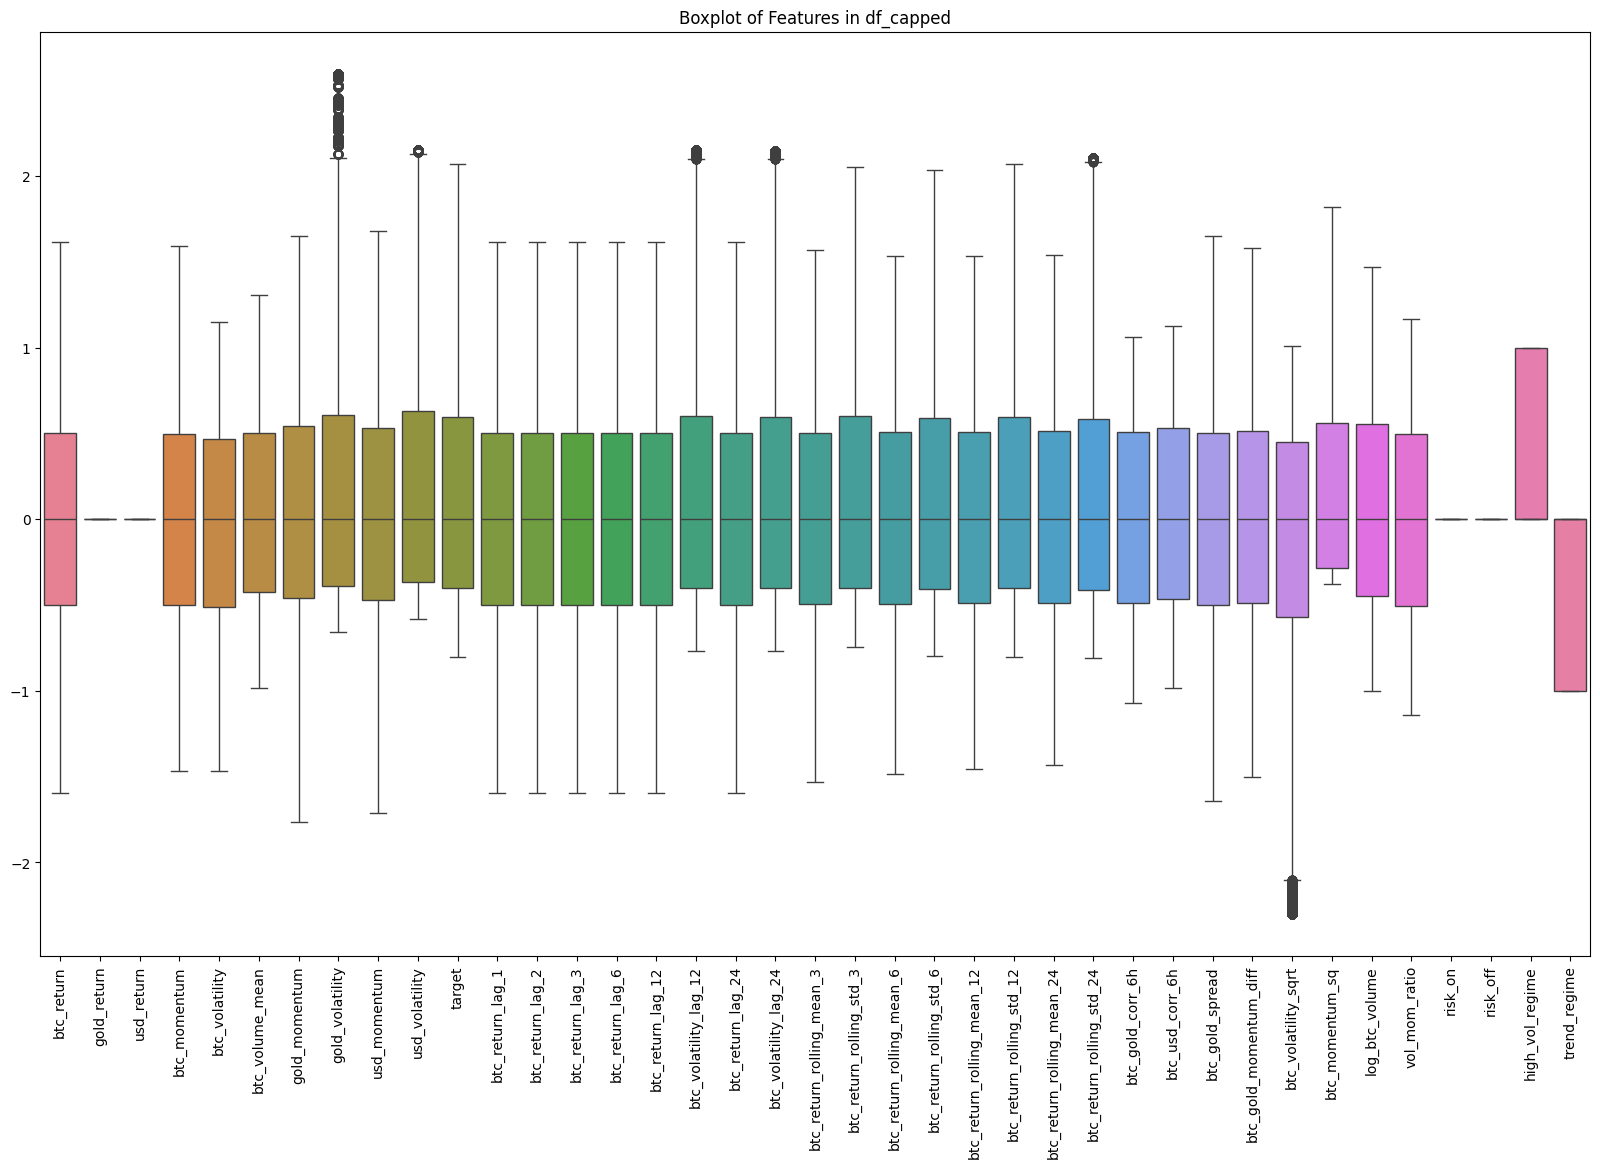

In [30]:
plt.figure(figsize=(20,12))
sns.boxplot(data=df_capped)
plt.xticks(rotation=90)
plt.title('Boxplot of Features in df_capped')
plt.show()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

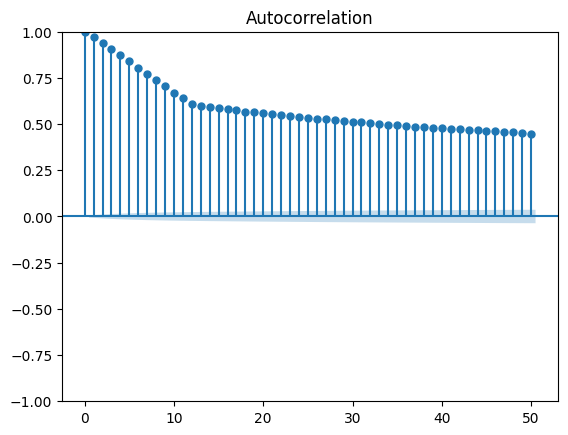

In [30]:

plot_acf(df_capped['target'], lags=50)
plt.show()



<Axes: >

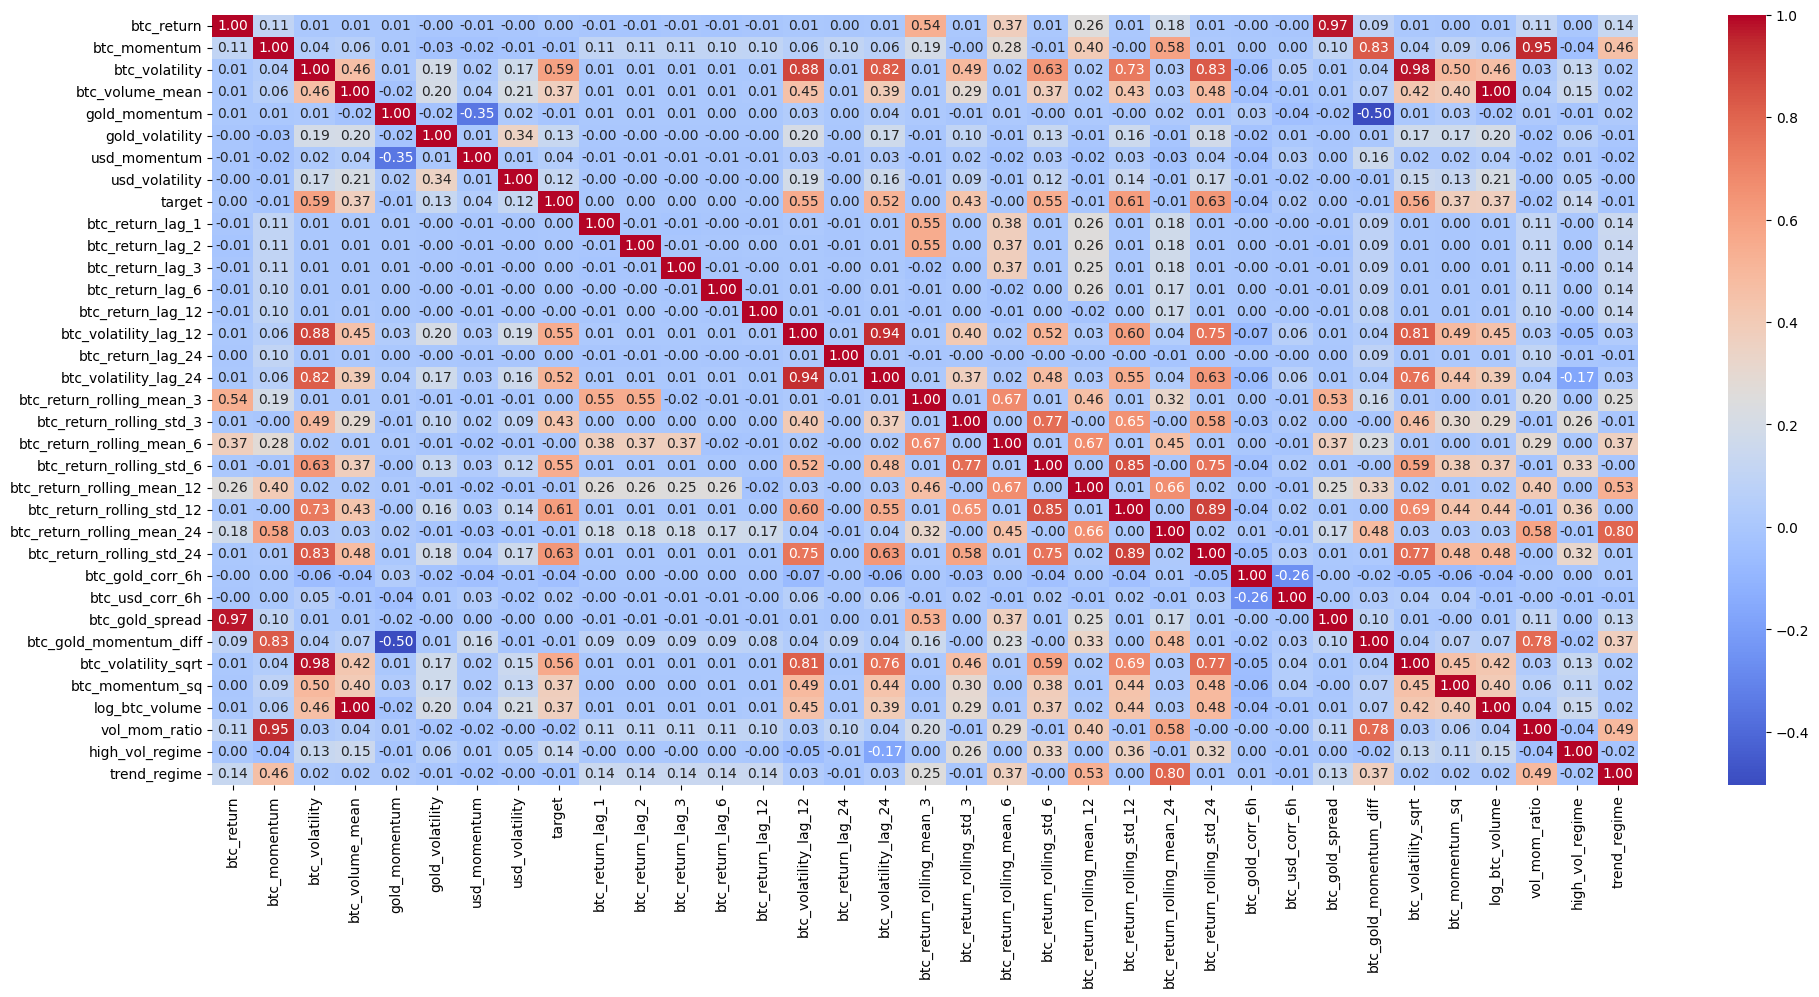

In [47]:
plt.figure(figsize=(23,10))
sns.heatmap(df_capped.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [45]:
df_capped.drop(columns=['gold_return','usd_return','risk_on','risk_off'],inplace=True)

In [33]:
feature_names = df_capped.drop(columns=['target']).columns.tolist()
print(len(feature_names))
print(feature_names)

38
['btc_return', 'gold_return', 'usd_return', 'btc_momentum', 'btc_volatility', 'btc_volume_mean', 'gold_momentum', 'gold_volatility', 'usd_momentum', 'usd_volatility', 'btc_return_lag_1', 'btc_return_lag_2', 'btc_return_lag_3', 'btc_return_lag_6', 'btc_return_lag_12', 'btc_volatility_lag_12', 'btc_return_lag_24', 'btc_volatility_lag_24', 'btc_return_rolling_mean_3', 'btc_return_rolling_std_3', 'btc_return_rolling_mean_6', 'btc_return_rolling_std_6', 'btc_return_rolling_mean_12', 'btc_return_rolling_std_12', 'btc_return_rolling_mean_24', 'btc_return_rolling_std_24', 'btc_gold_corr_6h', 'btc_usd_corr_6h', 'btc_gold_spread', 'btc_gold_momentum_diff', 'btc_volatility_sqrt', 'btc_momentum_sq', 'log_btc_volume', 'vol_mom_ratio', 'risk_on', 'risk_off', 'high_vol_regime', 'trend_regime']


In [46]:
df_capped.columns

Index(['btc_return', 'btc_momentum', 'btc_volatility', 'btc_volume_mean',
       'gold_momentum', 'gold_volatility', 'usd_momentum', 'usd_volatility',
       'target', 'btc_return_lag_1', 'btc_return_lag_2', 'btc_return_lag_3',
       'btc_return_lag_6', 'btc_return_lag_12', 'btc_volatility_lag_12',
       'btc_return_lag_24', 'btc_volatility_lag_24',
       'btc_return_rolling_mean_3', 'btc_return_rolling_std_3',
       'btc_return_rolling_mean_6', 'btc_return_rolling_std_6',
       'btc_return_rolling_mean_12', 'btc_return_rolling_std_12',
       'btc_return_rolling_mean_24', 'btc_return_rolling_std_24',
       'btc_gold_corr_6h', 'btc_usd_corr_6h', 'btc_gold_spread',
       'btc_gold_momentum_diff', 'btc_volatility_sqrt', 'btc_momentum_sq',
       'log_btc_volume', 'vol_mom_ratio', 'high_vol_regime', 'trend_regime'],
      dtype='object')

In [37]:
X= df_capped.drop(columns=['target'])
y= df_capped['target']

In [38]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    print(f"TRAIN indices: {train_index}, VAL indices: {val_index}")

TRAIN indices: [    0     1     2 ... 25997 25998 25999], VAL indices: [26000 26001 26002 ... 51997 51998 51999]
TRAIN indices: [    0     1     2 ... 51997 51998 51999], VAL indices: [52000 52001 52002 ... 77997 77998 77999]
TRAIN indices: [    0     1     2 ... 77997 77998 77999], VAL indices: [ 78000  78001  78002 ... 103997 103998 103999]


In [50]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
results = []
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=15,
        cv=tscv,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        refit=True,
        verbose=1
    )
    search.fit(X, y)
    best_models[name] = search.best_estimator_
    results.append({
        'Model': name,
        'Best Score': search.best_score_,
        'Best Params': search.best_params_
    })

results_df = pd.DataFrame(results).sort_values(by='Best Score', ascending=False)
print(results_df)


Tuning DecisionTree...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning RandomForest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning ExtraTrees...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning AdaBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\naman\OneDrive\Desktop\delta_Exchange_india\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning GradientBoosting...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning XGB...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning LGBM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8164
[LightGBM] [Info] Number of data points in the train set: 104000, number of used features: 34
[LightGBM] [Info] Start training from score 0.185944
              Model  Best Score  \
2        ExtraTrees    0.429539   
4  GradientBoosting    0.429249   
5               XGB    0.423747   
6              LGBM    0.410140   
1      RandomForest    0.390216   
3          AdaBoost    0.381814   
0      DecisionTree    0.371927   

                                         Best Params  
2  {'n_estimators': 200, 'min_samples_split': 10,...  
4  {'n_estimators': 200, 'm

In [51]:
results

[{'Model': 'DecisionTree',
  'Best Score': np.float64(0.37192684985479546),
  'Best Params': {'min_samples_split': 10,
   'min_samples_leaf': 5,
   'max_depth': 5}},
 {'Model': 'RandomForest',
  'Best Score': np.float64(0.39021631179569516),
  'Best Params': {'n_estimators': 100,
   'min_samples_split': 10,
   'min_samples_leaf': 5,
   'max_depth': 10}},
 {'Model': 'ExtraTrees',
  'Best Score': np.float64(0.4295393540977175),
  'Best Params': {'n_estimators': 200,
   'min_samples_split': 10,
   'max_depth': 10}},
 {'Model': 'AdaBoost',
  'Best Score': np.float64(0.3818135199199085),
  'Best Params': {'n_estimators': 200, 'learning_rate': 0.01}},
 {'Model': 'GradientBoosting',
  'Best Score': np.float64(0.42924903069557824),
  'Best Params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}},
 {'Model': 'XGB',
  'Best Score': np.float64(0.42374663569014154),
  'Best Params': {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}},
 {'Model': 'LGBM',
  'Best Score': np.f

In [52]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel, RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(
        hp.Int('units_input', min_value=128, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_input', 0.1, 0.4, step=0.1)))

    # Hidden layer 1
    model.add(layers.Dense(
        hp.Int('units_hidden1', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_hidden1', 0.1, 0.4, step=0.1)))

    # Hidden layer 2
    model.add(layers.Dense(
        hp.Int('units_hidden2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Output layer
    model.add(layers.Dense(1))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae']
    )
    return model


In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(hp.Int('units_input', 64, 256, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_input', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('units_hidden1', 32, 128, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_hidden1', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('units_hidden2', 32, 128, step=32), activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model

X = df_capped.drop(columns=['target']).values
y = df_capped['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='volatility_nn_tuning'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

final_model = build_model(best_hps)
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='mse',
    metrics=['mae']
)

final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

val_loss, val_mae = final_model.evaluate(X_val, y_val)
print("Validation MAE:", val_mae)

Reloading Tuner from my_tuner_dir\volatility_nn_tuning\tuner0.json
units_input: 192
dropout_input: 0.30000000000000004
units_hidden1: 96
dropout_hidden1: 0.4
units_hidden2: 64
learning_rate: 0.000791524243562959
Epoch 1/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3563 - mae: 0.4540 - val_loss: 0.3666 - val_mae: 0.4635
Epoch 2/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3306 - mae: 0.4374 - val_loss: 0.3712 - val_mae: 0.4649
Epoch 3/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3251 - mae: 0.4336 - val_loss: 0.3446 - val_mae: 0.4556
Epoch 4/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3206 - mae: 0.4306 - val_loss: 0.3437 - val_mae: 0.4507
Epoch 5/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3181 - mae: 0.4287 - val_loss: 0.3266 - val_mae: 0.4454
Epoch 6/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3154 - mae: 0.4266 - val_loss: 0.3371 - val_mae: 0.4517
Epoch 7/50
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3128

In [54]:
final_model = keras.Sequential([
    layers.Dense(192, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(96, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000791524243562959),
    loss='mse',
    metrics=['mae']
)

history = final_model.fit(
    X_scaled, y,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100


c:\Users\naman\OneDrive\Desktop\delta_Exchange_india\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2600/2600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4137 - mae: 0.4905 - val_loss: 0.3397 - val_mae: 0.4381
Epoch 2/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3453 - mae: 0.4489 - val_loss: 0.3228 - val_mae: 0.4231
Epoch 3/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3382 - mae: 0.4438 - val_loss: 0.3199 - val_mae: 0.4238
Epoch 4/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3342 - mae: 0.4414 - val_loss: 0.3170 - val_mae: 0.4249
Epoch 5/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3304 - mae: 0.4387 - val_loss: 0.3164 - val_mae: 0.4232
Epoch 6/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3277 - mae: 0.4369 - val_loss: 0.3183 - val_mae: 0.4262
Epoch 7/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3241 - mae: 0.4340 - val_loss: 0.3178 - val_mae: 0.4249
Epoch 8/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3204 - mae: 0.4318 - val_loss: 0.3210 - val_mae: 0.4264
Epoch 9/100
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8

In [55]:
from sklearn.metrics import r2_score

y_pred = final_model.predict(X_val)
print("R2 Score:", r2_score(y_val, y_pred))


650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
R2 Score: 0.5014190509157345


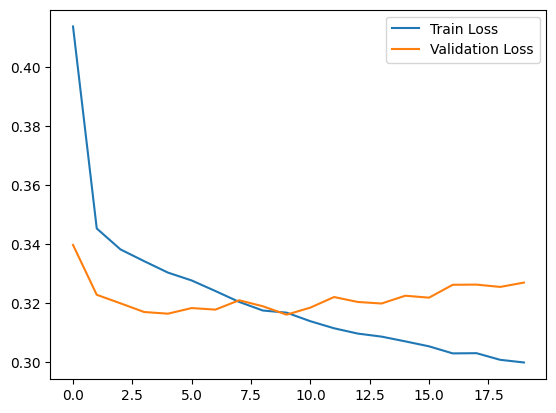

In [56]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [57]:
y_pred = final_model.predict(X_val).flatten()

650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


In [58]:
signals = np.where(y_pred > 0, 1, -1)
returns = signals * y_val

In [59]:
import numpy as np
total_return = np.sum(returns)
annual_return = np.mean(returns) * 252
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
sortino = np.mean(returns) / np.std(returns[returns < 0]) * np.sqrt(252)
hit_rate = np.mean(returns > 0)
profit_factor = np.sum(returns[returns > 0]) / abs(np.sum(returns[returns < 0]))
cumulative = np.cumsum(returns)
running_max = np.maximum.accumulate(cumulative)
drawdown = running_max - cumulative
max_drawdown = np.max(drawdown)
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Annualized Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Hit Rate: {hit_rate:.4f}")
print(f"Profit Factor: {profit_factor:.4f}")


Max Drawdown: 4.5656
Total Return: 8954.5978
Annualized Return: 108.4884
Sharpe Ratio: 10.1783
Sortino Ratio: 19.3401
Hit Rate: 0.7629
Profit Factor: 5.9947


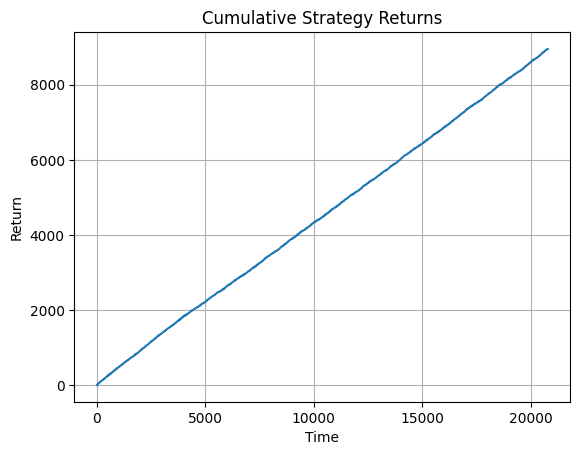

In [60]:
import matplotlib.pyplot as plt

cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.title("Cumulative Strategy Returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.show()

In [61]:
#Testing data
split_index = int(len(df_capped) * 0.8)
train_df = df_capped.iloc[:split_index]
test_df = df_capped.iloc[split_index:]

In [62]:
scaler = StandardScaler()
X_train = train_df.drop(columns=['target']).values
y_train = train_df['target'].values
X_test = test_df.drop(columns=['target']).values
y_test = test_df['target'].values

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
final_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

y_pred = final_model.predict(X_test_scaled).flatten()

Epoch 1/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3163 - mae: 0.4294 - val_loss: 0.2865 - val_mae: 0.4064
Epoch 2/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3143 - mae: 0.4279 - val_loss: 0.2905 - val_mae: 0.4073
Epoch 3/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3111 - mae: 0.4256 - val_loss: 0.2960 - val_mae: 0.4056
Epoch 4/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3102 - mae: 0.4249 - val_loss: 0.2951 - val_mae: 0.4095
Epoch 5/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3079 - mae: 0.4237 - val_loss: 0.2991 - val_mae: 0.4090
Epoch 6/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3063 - mae: 0.4228 - val_loss: 0.3003 - val_mae: 0.4093
Epoch 7/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3048 - mae: 0.4208 - val_loss: 0.3068 - val_mae: 0.4131
Epoch 8/100
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3036 - mae: 0.4207 - val_loss: 0.3054 - val_mae: 0.4103
Epoch 9/100
2080/2080 ━━━━━━━━

In [64]:
signals = np.where(y_pred > 0, 1, -1)
returns = signals * y_test



In [66]:
total_return = np.sum(returns)
annual_return = np.mean(returns) * 252
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
sortino = np.mean(returns) / np.std(returns[returns < 0]) * np.sqrt(252)
hit_rate = np.mean(returns > 0)
profit_factor = np.sum(returns[returns > 0]) / abs(np.sum(returns[returns < 0]))
cumulative = np.cumsum(returns)
running_max = np.maximum.accumulate(cumulative)
drawdown = running_max - cumulative
max_drawdown = np.max(drawdown)
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Annualized Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Hit Rate: {hit_rate:.4f}")
print(f"Profit Factor: {profit_factor:.4f}")


Max Drawdown: 37.3075
Total Return: 8947.3409
Annualized Return: 108.4005
Sharpe Ratio: 10.0290
Sortino Ratio: 19.0518
Hit Rate: 0.7573
Profit Factor: 5.7279


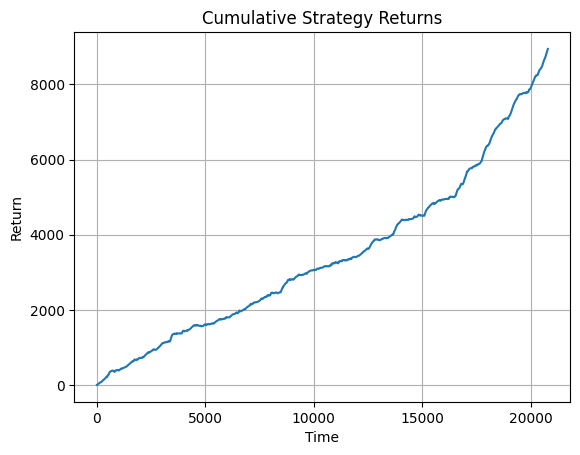

In [67]:
cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.title("Cumulative Strategy Returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.show()

In [68]:
import yfinance as yf

btc = yf.download('BTC-USD', start='2025-04-01', end='2025-10-23', interval='1h')
btc['return'] = btc['Close'].pct_change().fillna(0)

C:\Users\naman\AppData\Local\Temp\ipykernel_39388\1261515107.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2025-04-01', end='2025-10-23', interval='1h')
[*********************100%***********************]  1 of 1 completed


In [69]:
btc_returns = btc['return'].values[:len(returns)]  # align length
btc_cumulative = np.cumsum(btc_returns)

btc_sharpe = np.mean(btc_returns) / np.std(btc_returns) * np.sqrt(252)
btc_total_return = np.sum(btc_returns)

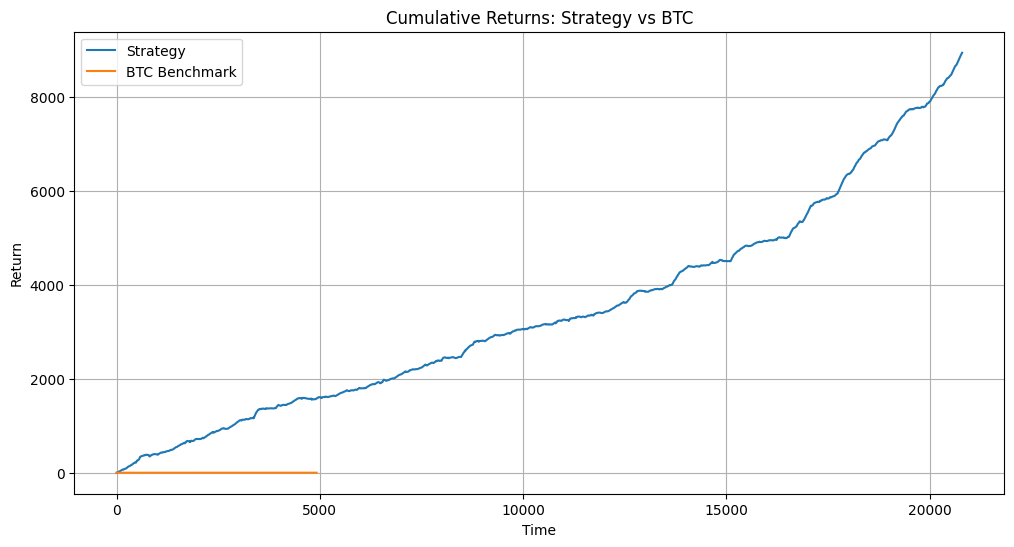

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(returns), label='Strategy')
plt.plot(btc_cumulative, label='BTC Benchmark')
plt.title("Cumulative Returns: Strategy vs BTC")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
import pickle
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)